<h1 align="center"> Подпись к изображению </h1>

В этом блокноте вы научите сеть делать подписи к изображениям.
![img](https://cdn-images-1.medium.com/max/716/1*vzFwXFJOrg6WRGNsYYT6qg.png)
_изображение [источник](https://towardsdatascience.com/image-captioning-in-deep-learning-9cd23fb4d8d2)_



#### Хорошо, вот наш план:
1. Возьмите предварительно обученный inception v3  для векторизации изображений.
2. Сложите LSTM поверх него
3. Тренируйтесь на [MSCOCO](http://cocodataset.org/#download)
4.  нужно сделать улучшения "Внимание" и "Подписи на уровне подслов"

**Основано на реальных событиях и yandexdataschool*


### Data preprocessing

Тут есть частично код который работает на tensorflow version 1. Чтобы использовать его в Colab - необходимо выполнить волшебную команду

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!pip install scipy==1.1.0 # и перезапустить среду
import scipy

In [ ]:
# Загрузите данные с https://yadi.sk/d/b4nAwIE73TVcp5 или сгенерируйте их вручную с помощью preprocess_data.

Чтобы сэкономить ваше время, мы уже векторизовали все изображения MSCOCO17 с помощью предварительно обученной сети inception_v3 от torchvision. (https://yadi.sk/d/b4nAwIE73TVcp5)

Весь процесс занимает от дня на CPU до 10 минут на 3x tesla m40. Если вы хотите поиграть с этим самостоятельно, [добро пожаловать] (https://github.com/sw-shar/Image-Captioning/blob/main/preprocess_data.ipynb).

In [3]:

import torch, torch.nn as nn
import torch.nn.functional as F

import numpy as np
import json

import os
import pandas as pd

import torch, torch.nn as nn
import torch.nn.functional as F
from torchvision.models.inception import Inception3
from torch.utils.model_zoo import load_url
from warnings import warn

from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline
import pandas as pd


In [ ]:
!tar -xf /content/handout.tar.gz # https://yadi.sk/d/b4nAwIE73TVcp5

In [7]:
img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

### Структура данных

Чтобы сэкономить ваше время, мы уже векторизовали все изображения MSCOCO17 с помощью предварительно обученной сети inception_v3 от [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

Весь процесс занимает от дня на CPU до 10 минут на 3x tesla m40. Если вы хотите поиграть с этим самостоятельно, [добро пожаловать] (https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [8]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как видите, все подписи уже токенизированы и прописаны в нижнем регистре. Теперь мы хотим разделить их и добавить несколько специальных токенов для начала/конца подписи.

In [9]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


Вы же не хотите, чтобы ваша сеть предсказывала миллионный вектор вероятностей на каждом шаге, поэтому мы должны сделать некоторые сокращения.

Мы хотим, чтобы вы __подсчитали количество вхождений каждого слова__, чтобы мы могли решить, какие слова оставить в нашем словаре.

In [10]:
# Создайте словарный запас
from collections import Counter

#Вычислите частоты слов для каждого слова в подписях. См. код выше для структуры данных
all_wowds = [a for pr in captions for i in pr for a in i]
word_counts = Counter(all_wowds)

In [11]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [12]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Преобразование списка токенов в матрицу с дополнением"""
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [13]:
#попробуйте несколько описаний случайного изображения
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Создание нашей нейронной сети

Как мы упоминали ранее, мы построим rnn «языковую модель», основанную на векторах из сверточной части.

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_изображение: http://bit.ly/2FKnqHm_


Мы распакуем начальную сеть позже, чтобы сэкономить память, а сейчас просто представьте, что она доступна.


In [14]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ Рекуррентная «головная» сеть для подписи к изображениям. См. схему выше. """
        super(self.__class__, self).__init__()
        
         # слой, который преобразует конвекционные функции в
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # повторяющаяся часть, пожалуйста, создайте слои в соответствии со схемой выше.

        # создать вложение для входных слов. Используйте параметры (например, emb_size).
        #Этот модуль часто используется для хранения вложений слов и их извлечения с использованием индексов.
        #Вход в модуль — это список индексов, а выход — соответствующие вложения слов.
        self.emb = nn.Embedding(n_tokens,emb_size,)
            
        # lstm: создайте повторяющееся ядро вашей сети. Используйте либо LSTMCell, либо просто LSTM.
        # В последнем случае (nn.LSTM) убедитесь, что batch_first=True
        #Применяет многоуровневую долговременную кратковременную память (LSTM) RNN к входной последовательности.
        # 2048,128,256
        self.lstm = nn.LSTM(emb_size,lstm_units, batch_first=True)
            
        # создать логиты: линейный слой, который принимает скрытое состояние 
        #lstm в качестве входных данных и вычисляет одно число для каждого токена
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Примените сеть в режиме обучения.
         image_vectors: тензор, содержащий начальные векторы. форма: [пакет, cnn_feature_size]
         captions_ix: тензор, содержащий подписи в качестве матрицы. форма: [партия, word_i].
             дополненный pad_ix
         :returns: логиты для следующего токена на каждом тике, форма: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        #print(initial_cell.shape)

        
        #вычислить вложения для captions_ix
        captions_emb = self.emb(captions_ix)
        #print(captions_ix.shape)
        #print(captions_emb.shape)
        
        # применить рекуррентный слой к captions_emb.
         # 1. Инициализировать состояние lstm с помощью initial_* сверху
         # 2. Подкормите его подписями. Следите за порядком измерений в строке документации
         # 3. вычислить логиты для вероятностей следующих токенов
         # Примечание: если вы использовали nn.LSTM, вы можете просто указать его (initial_cell[None], initial_hid[None]) в качестве второго аргумента

         # lstm_out должен быть скрытой последовательностью состояний lstm формы [batch, caption_length, lstm_units]
        lstm_out , _ = self.lstm(captions_emb,(initial_cell[None], initial_hid[None]))
        
        # вычислить логиты из lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [15]:
network = CaptionNet(n_tokens)

In [16]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [17]:
from torch.nn import CrossEntropyLoss

In [18]:
def compute_loss(network, image_vectors, captions_ix):
    """

    Возвращаем ошибку cross_entropy сети network для подписи logits_for_next к картинке


    image_vectors: тензор факела, содержащий начальные векторы. форма: [пакет, cnn_feature_size]
    captions_ix: тензор torch, содержащий подписи в качестве матрицы. форма: [партия, word_i].
         дополненный pad_ix
     :returns: crossentropy loss (neg llh) потеря для следующих captions_ix с учетом предыдущих.
      Скалярный плавающий тензор
    """
    
    # подписи для ввода - все, кроме последнего, потому что мы не знаем следующий токен для последнего.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # применить сеть, получить прогнозы для captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)

 
    
    # вычислить функцию потерь между logits_for_next и captions_ix_next
     # Используйте маску, Люк: убедитесь, что предсказание следующих токенов после EOS не способствует потере
     # вы можете сделать это либо путем умножения поэлементной потери на (captions_ix_next != pad_ix)
     # или используя ignore_index в некоторых потерях.
    
    # unsqueeze Возвращает новый тензор с размерностью один, вставленный в указанную позицию.
    #print(logits_for_next.shape)
    #print(captions_ix_next.shape)
    #print(logits_for_next.permute(0,2,1).shape)    
    loss = F.cross_entropy(logits_for_next.permute(0,2,1), captions_ix_next, ignore_index=pad_ix).unsqueeze(dim=0)
    
    return loss

In [19]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert len(dummy_loss.shape) <= 1, 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Создайте свой любимый оптимизатор для сети.

torch.optim представляет собой пакет, реализующий различные алгоритмы оптимизации. Наиболее часто используемые методы уже поддерживаются, а интерфейс достаточно общий, чтобы в будущем можно было легко интегрировать более сложные методы.

In [20]:
params = network.parameters()

optimaizer = torch.optim.NAdam(params, lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, momentum_decay=0.004)

## Обучение

* Сначала реализуйте пакетный генератор
* Чем тренировать сеть как обычно

In [21]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [22]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #образцы случайных чисел для индексов изображений/заголовков
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #получить изображения
    batch_images = img_codes[random_image_ix]
    
    #5-7 подписи к каждому изображению
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #преобразовать в матрицу
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

In [23]:
generate_batch(img_codes,captions,3)

(tensor([[0.1451, 0.1565, 0.7361,  ..., 0.0008, 0.4918, 0.2240],
         [0.2603, 0.2097, 0.4187,  ..., 0.0000, 0.3044, 0.5611],
         [0.1250, 0.0695, 0.3033,  ..., 0.0000, 0.2809, 0.3743]]),
 tensor([[   1,   24, 1117,  613,  610,   51,  239,    6,   45,  487,   12,    2,
             3,    3],
         [   1,   24,  102,   14,   24,  115,  279,   94,   35,   24,  915,   12,
             2,    3],
         [   1,  360,   41,   24,   57,  234,   24,   47,  257,  170,   58,   24,
            52,    2]]))

## Основной цикл

Тренируйтесь на мини-партиях, как обычно. Время от времени оценивайте значение val.

##### Подсказки
* Если потери при обучении стали близки к 0 или модель производит мусор,
    дважды проверьте, что вы предсказываете __следующие__ слова, а не текущие или t+2-е слова.
* Если модель генерирует беглые подписи, которые не имеют ничего общего с изображениями
 * это может быть связано с тем, что рекуррентная сеть не получает векторы изображений.
 * в качестве альтернативы это может быть вызвано взрывом градиента, попробуйте обрезать их или просто перезапустите тренировку
 * наконец, вам может понадобиться немного больше обучить модель


* Кроссэнтропия — плохой показатель переобучения.
 * Модель может превосходить кроссэнтропию валидации, но продолжать улучшать качество валидации.
 * Используйте _(ручную)_ оценку вручную или попробуйте автоматизированные показатели: [cider](https://github.com/vrama91/cider) или [bleu](https://www.nltk.org/_modules/nltk/translate /bleu_score.html)
 

* Мы рекомендуем вам периодически оценивать сеть, используя следующий блок «применить обученную модель».
 * можно безопасно прервать обучение, запустить несколько примеров и снова начать обучение
 
* Типичные значения потерь должны составлять около 3–5, если вы усредняете по времени, масштабируйте по длине, если вы суммируете по времени. Разумные титры стали появляться при loss=2.8 ~ 3.0
 

In [24]:
batch_size = 50  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # сколько пакетов используется для проверки после каждой эпохи

In [25]:
need_Teach = False #заглушка на обучение сети, поставить True 
if need_Teach:
  from tqdm import tqdm

  for epoch in range(n_epochs):
      
      train_loss=0
      network.train(True)
      for _ in tqdm(range(n_batches_per_epoch)):
          
          loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
          
          # очистить градиенты
          optimaizer.zero_grad() # Устанавливает градиенты всех оптимизированных torch.Tensors равными нулю.

          #сделать обратный проход
          loss_t.backward() # backward вычисляет градиент текущего тензора относительно листьев графа.

          # получить новые градиенты
          optimaizer.step() # optimizer.step выполняет обновление параметра на основе текущего градиента
          
          
          train_loss += loss_t.detach().numpy() # detach Возвращает новый тензор, отсоединенный от текущего графа
          
      train_loss /= n_batches_per_epoch
      
      val_loss=0
      network.train(False)
      for _ in range(n_validation_batches):
          loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
          val_loss += loss_t.detach().numpy()
      val_loss /= n_validation_batches
      
      print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

  print("Finished!")



## Применить обученную модель

Давайте распакуем нашу предварительно обученную начальную сеть и посмотрим, на что способна наша модель.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
network.load_state_dict(torch.load('/content/drive/MyDrive/учеба/ВЫШКА/НЕЙРО_СЕТИ/3_homework_network.pth'))

<All keys matched successfully>

In [27]:
class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x
    

def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.load_state_dict(load_url(inception_url))
    return model

In [28]:
#from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:48: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

### Создать заголовок

Приведенная ниже функция создает подписи путем выборки из вероятностей, определенных сетью.

Используемая здесь реализация проста, но неэффективна (квадратична по шагам lstm). Мы оставляем его таким, поскольку это не является узким местом в производительности.

In [29]:
def generate_caption(image, caption_prefix = ("#START#",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
    
    vectors_8x8, vectors_neck, logits = inception(image[None]) # загоняем картинку в сеть inception и получаем 3 представления
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        # переводим в тензор наш START
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)

        # используем выход сети vectors_neck размерностью 2048 и тензор по факту который только задает START
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]

        #получаем вектор внимания и применяем softmax
        next_word_probs = F.softmax(next_word_logits, -1).detach().numpy()
        
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

# Демо
### 10 изображений, чтобы протестировать его.


In [32]:
!cd /content
!rm -R /content/Image-Captioning
!git clone https://github.com/sw-shar/Image-Captioning

rm: cannot remove '/content/Image-Captioning': No such file or directory
Cloning into 'Image-Captioning'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 75 (delta 24), reused 65 (delta 14), pack-reused 0
Unpacking objects: 100% (75/75), done.


In [33]:
dir2 = '/content/Image-Captioning/test/images'
name = []
for dirname, _, filenames in os.walk(dir2):
    for filename in filenames:
      name.append([dirname.split('/')[-1], os.path.join(dirname, filename)])

df = pd.DataFrame(columns = ['category', 'way'], data = name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


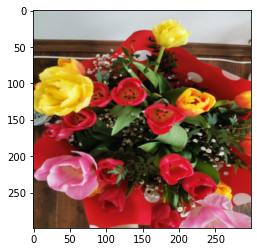

a bunch of bananas hanging from a tree .
a bunch of bananas are hanging from a tree .
a bunch of flowers in a vase with flowers in it .
a bunch of flowers in a vase on a table .
a bunch of flowers in a vase on a table .
a bunch of bananas hanging from a tree .
a bunch of flowers are in a vase on a table .
a bunch of bananas hanging from a tree .
a vase with flowers in it on a table .
a bunch of ripe bananas hanging from a tree .


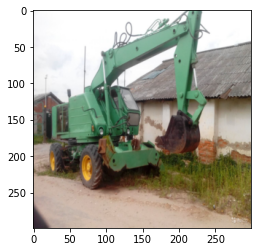

a man is standing in the woods with a red and white truck .
a man is standing in the snow with a red and white truck .
a man is standing in the snow with a large truck .
a man is riding a horse on a road .
a man is riding a horse in the street .
a man is riding a horse on a road .
a man is riding a horse in the street .
a man is standing in a park with a yellow fire hydrant .
a truck is parked in a parking lot .
a man is standing in the snow with a yellow fire hydrant .


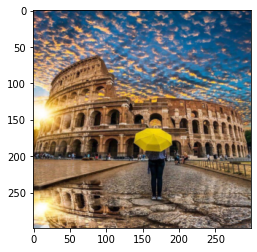

a man is walking across a beach holding a kite .
a man is flying a kite on the beach .
a man is walking with a large kite in the sky .
a man is walking with a kite in the air .
a man is walking across a street holding a kite .
a man is walking down the street holding a kite .
a man flying a kite at a beach .
a man flying a kite in the sky .
a large tower with a clock on it
a man is walking down a street holding a kite .


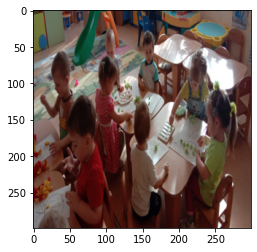

a group of people are gathered around a table .
a group of people are gathered around a table .
a group of people are gathered around a table .
a group of people are gathered around a table .
a group of people are gathered around a table .
a group of people standing around a table with a cake on it .
a group of people are gathered around a table .
a group of people are gathered around a table .
a group of people are gathered around a table .
a group of people are gathered around a table .


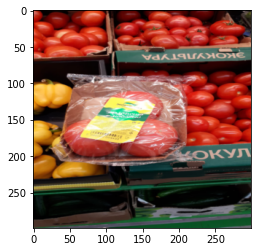

a bunch of ripe bananas sitting on a table .
a bunch of ripe bananas sitting on a table .
a bunch of bananas are on a table .
a bunch of ripe bananas and oranges in a bowl .
a fruit stand with a lot of fruits and vegetables .
a bunch of bananas and a bowl of fruit .
a table with a lot of fruit and vegetables
a bunch of ripe bananas hanging from a tree .
a bunch of ripe bananas sitting on a table .
a bunch of bananas are on a table .


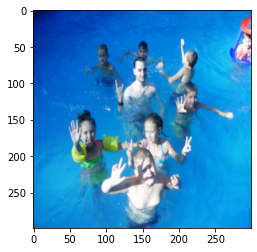

a man holding a frisbee in a park .
a man is playing with a frisbee in his hand .
a man in a black shirt is playing with a frisbee .
a group of people playing soccer on a field .
a man holding a frisbee in his hand .
a man is playing with the ball in the air .
a group of people playing with a frisbee .
a man is playing with a frisbee in the park .
a group of people playing frisbee in the grass .
a man in a blue shirt and a frisbee .


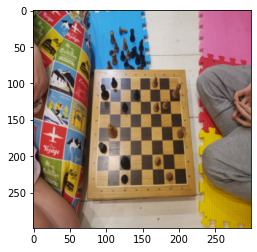

a man holding a cell phone in his hand .
a man holding a hot dog and a drink .
a man holding a hot dog and a drink .
a man holding a cell phone in his hand .
a man holding a hot dog and a drink .
a man holding a cell phone in his hand .
a man holding a camera and a banana .
a man holding a hot dog and a drink .
a man holding a hot dog with a knife .
a man holding a cell phone in his hand .


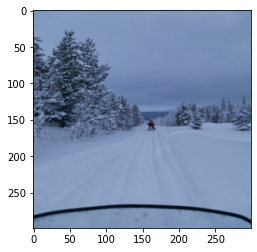

a person riding a snowboard down a snow covered slope .
a man riding a skateboard on a rail .
a person riding a snowboard down a snow covered slope .
a person on a snowboard in the snow .
a person riding a snowboard down a snow covered slope .
a man riding a snowboard down a snow covered slope .
a person riding a snowboard down a snow covered slope .
a man riding a skateboard on a snow covered ground .
a person riding a snowboard down a snow covered slope .
a man riding a skateboard on a rail .


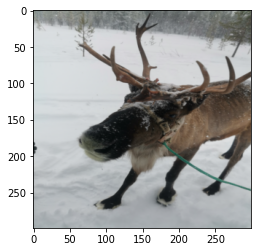

a man is riding a horse on a dirt road .
a man is sitting on a horse with a dog .
a man in a red jacket is riding a horse .
a man is sitting on a horse with a dog .
a horse is standing in the grass with a brown and white cow .
a man is sitting on a horse with his dog .
a cow is standing in the snow with a fence .
a man in a white shirt and a white horse
a man is sitting on a horse in a field .
a man riding a horse on a track


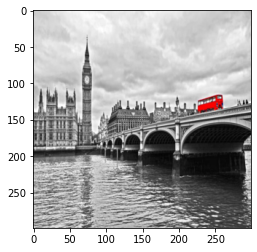

a boat is sitting on the beach at a beach .
a boat is sitting on the beach at a beach .
a boat is sitting on the beach by a body of water .
a boat is sitting in the water near a body of water .
a boat in a body of water with a large ship in the background .
a large boat is sitting in the water .
a boat is sitting in the water near a body of water .
a boat is sitting in the water near a body of water .
a boat is sitting on the beach near a body of water .
a boat is sitting on the shore of a beach .


In [34]:
for strok in df['way']:

  img = plt.imread(strok)
  img = imresize(img, (299, 299)).astype('float32') / 255.

  plt.imshow(img)
  plt.show()

  for i in range(10):
      print(' '.join(generate_caption(img, t=5.)[1:-1]))

### Что теперь?

### Внимание
Вы можете построить лучшую и более интерпретируемую модель субтитров с вниманием.
* Как это работает: https://distill.pub/2016/augmented-rnns/
* Один из способов сделать это в субтитрах: https://arxiv.org/abs/1502.03044
* Вам нужно будет создать набор данных для внимания с помощью [этой записной книжки] (https://github.com/sw-shar/Image-Captioning/blob/main/preprocess_data.ipynb).



Предобученную модель с конфигурацией по умолчанию можно скачать здесь. (https://app.box.com/s/xuigzzaqfbpnf76t295h109ey9po5t8p
) Эта модель была обучена исключительно на данных COCO train2014. 

Реализация частично основана на (https://github.com/DeepRNN/image_captioning)

### Пред=загрузка

In [35]:
!curl http://images.cocodataset.org/annotations/annotations_trainval2014.zip > annotations_trainval2017.zip
!unzip annotations_trainval2017.zip
!rm -f annotations_trainval2017.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  241M  100  241M    0     0  48.1M      0  0:00:05  0:00:05 --:--:-- 45.6M
Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2014.json  
  inflating: annotations/instances_val2014.json  
  inflating: annotations/person_keypoints_train2014.json  
  inflating: annotations/person_keypoints_val2014.json  
  inflating: annotations/captions_train2014.json  
  inflating: annotations/captions_val2014.json  


In [ ]:
!tar -xf /content/289999.tar.gz # https://app.box.com/s/xuigzzaqfbpnf76t295h109ey9po5t8p

In [37]:
cd /content/Image-Captioning

/content/Image-Captioning


### Основа

In [ ]:
%tensorflow_version 1.x

In [38]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
from config import Config
from model import CaptionGenerator
from dataset import prepare_test_data, DataSet
from base_model import BaseModel
from config import Config
from utils.vocabulary import Vocabulary
from utils.coco import COCO

import nltk
nltk.download('punkt')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Тестирование

In [42]:
config = Config()
config.phase = 'test'
config.train_cnn = '/content/289999.npy' # предобученная модель
config.beam_size = 10


with tf.Session() as sess:
            #sess.graph._unsafe_unfinalize() # сбросить процесс обучения если что то пошло не так
            # data
            files = os.listdir('/content/Image-Captioning/test/images')
            image_files = [os.path.join('/content/Image-Captioning/test/images', f) for f in files
                      if f.lower().endswith('.jpg') or f.lower().endswith('.jpeg')]
            image_ids = list(range(len(image_files)))

            data = DataSet(image_ids, image_files, config.batch_size)


            # vocabulary_size
            max_caption_length = 20
            vocabulary_size = 5000
            vocabulary_file = './vocabulary.csv'
            train_caption_file = '/content/annotations/captions_train2014.json'

            def build_vocabulary():
                """ Создайте словарь из обучающих данных и сохраните его в файл. """
                coco = COCO(train_caption_file)
                coco.filter_by_cap_len(max_caption_length)

                vocabulary = Vocabulary(vocabulary_size)
                vocabulary.build(coco.all_captions())
                vocabulary.save(vocabulary_file)
                return vocabulary

            if not os.path.exists(vocabulary_file):
              vocabulary = build_vocabulary()
            else:
              vocabulary = Vocabulary(vocabulary_size, vocabulary_file) # если уже есть файл

            # Model
            model = CaptionGenerator(config)
            model.load(sess, config.train_cnn)
            tf.get_default_graph().finalize()
            model.test(sess, data, vocabulary)

Building the CNN...
CNN built.
Building the RNN...
RNN built.
ЗАГРУЗКА 
все загрузилось
Loading the model from /content/289999.npy...



100%|██████████| 48/48 [00:03<00:00, 13.21it/s]


Testing the model ...


path: 100%|██████████| 1/1 [01:04<00:00, 64.54s/it]

Testing complete.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
oll_test_data = pd.read_csv('/content/Image-Captioning/test/results.csv')

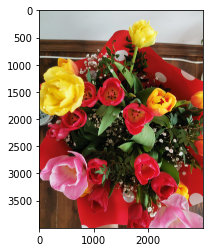

a vase filled with flowers on a table.




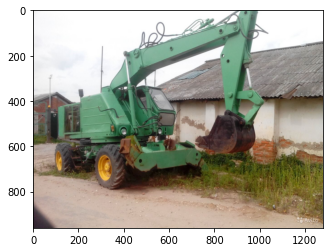

a green truck parked on the side of a road.




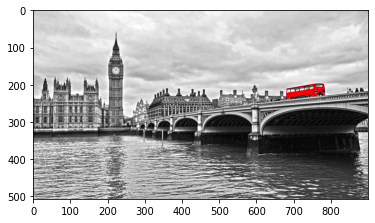

a large body of water with a clock tower.




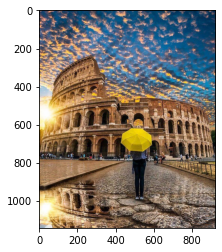

a man standing in front of a clock tower.




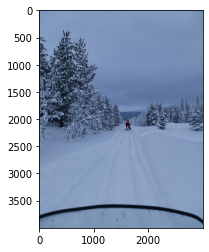

a person riding skis down a snow covered slope.




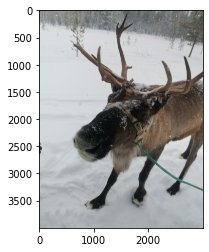

a couple of giraffes standing in the snow.




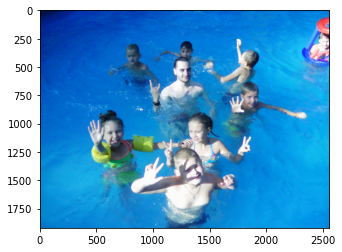

a group of people playing a game of frisbee.




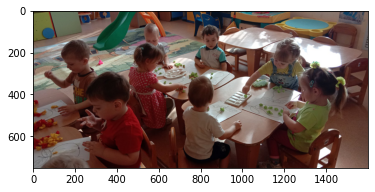

a group of people sitting around a table eating food.




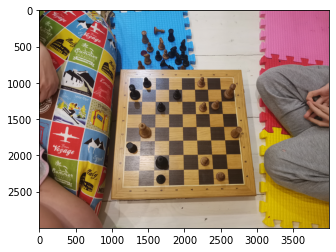

a person that is sitting on a bed.




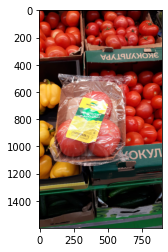

a ski case filled with all of oranges.



In [ ]:
for index, row in oll_test_data.iterrows():
  print()
  img = plt.imread(row['image_files'])

  plt.imshow(img)
  plt.show()
  print(row['caption'])
  print()